In [4]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

# Define transformation: convert to tensor and normalize to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor()
])

# Download and load the FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batching
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example: get the shape of the first training image
images, labels = next(iter(train_loader))
print(images[0].shape) 

torch.Size([1, 28, 28])


In [7]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes in Fashion MNIST
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Second conv block
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Flatten
        x = x.view(-1, 64 * 7 * 7)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [8]:
import matplotlib.pyplot as plt
import time

# Initialize the model
model = CNN()
# Move to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10

# Lists to store metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Training loop
for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate metrics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_val_loss = running_loss / len(test_dataset)
    epoch_val_acc = correct / total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    # Print statistics
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - {epoch_time:.1f}s - "
          f"Train loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.4f} - "
          f"Val loss: {epoch_val_loss:.4f}, Val acc: {epoch_val_acc:.4f}")

Using device: cpu
Epoch 1/10 - 50.9s - Train loss: 0.5022, Train acc: 0.8176 - Val loss: 0.3328, Val acc: 0.8805
Epoch 2/10 - 50.9s - Train loss: 0.3249, Train acc: 0.8826 - Val loss: 0.2975, Val acc: 0.8911
Epoch 3/10 - 50.3s - Train loss: 0.2789, Train acc: 0.8989 - Val loss: 0.2935, Val acc: 0.8959
Epoch 4/10 - 49.6s - Train loss: 0.2501, Train acc: 0.9092 - Val loss: 0.2577, Val acc: 0.9057
Epoch 5/10 - 54.6s - Train loss: 0.2264, Train acc: 0.9165 - Val loss: 0.2440, Val acc: 0.9100
Epoch 6/10 - 51.4s - Train loss: 0.2066, Train acc: 0.9237 - Val loss: 0.2503, Val acc: 0.9093
Epoch 7/10 - 71.1s - Train loss: 0.1912, Train acc: 0.9293 - Val loss: 0.2390, Val acc: 0.9145
Epoch 8/10 - 58.7s - Train loss: 0.1737, Train acc: 0.9351 - Val loss: 0.2398, Val acc: 0.9173
Epoch 9/10 - 47.7s - Train loss: 0.1594, Train acc: 0.9387 - Val loss: 0.2474, Val acc: 0.9158
Epoch 10/10 - 53.4s - Train loss: 0.1466, Train acc: 0.9445 - Val loss: 0.2292, Val acc: 0.9200


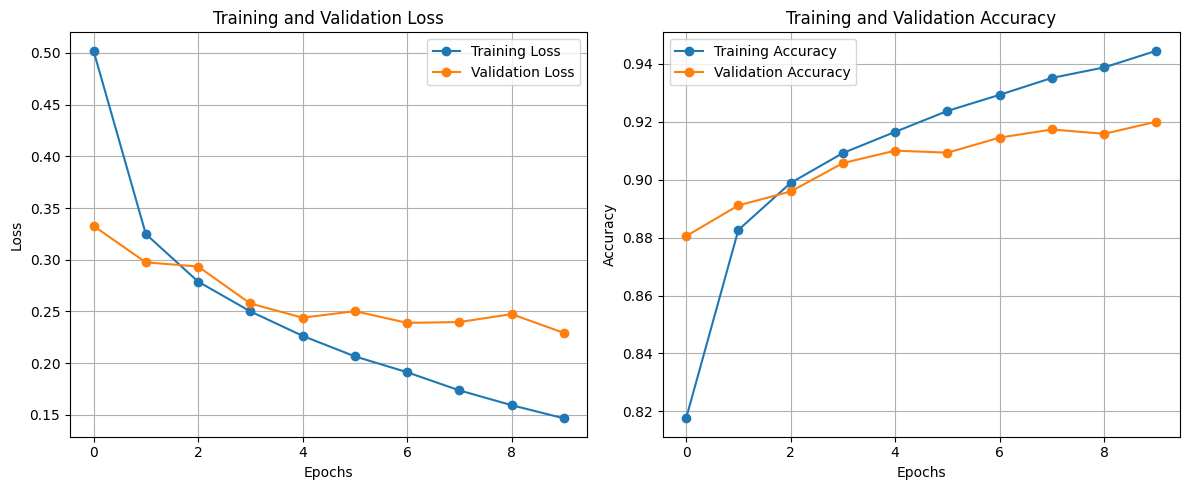

Final training accuracy: 0.9445
Final validation accuracy: 0.9200


In [9]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', marker='o')
plt.plot(val_accs, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final results
print(f"Final training accuracy: {train_accs[-1]:.4f}")
print(f"Final validation accuracy: {val_accs[-1]:.4f}")

In [29]:
##Testing Code